In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

1. Feature descriptors (SIFT SURF BRISK ORB)
2. Feature matching (BF L2norm/ Hamming=>bit wise comparison / KNN=>keep top K and search for best ratio) https://docs.opencv.org/3.4/d5/d6f/tutorial_feature_flann_matcher.html
-> i.e. when output top 2 features matches say, I1A =map=> I2A(I2A_d), I2B(I2B_d) where I2A_d < I2B_d
-> if I2A_d < 0.75 (I2B_d), it is a good match.
3. Ransac Fitting for Homography
=> Ransac fitting iteration
4. Homography fitting
5. Wrapping

In [2]:
"""
Ransac
@param:
@Iteration number: iter
@Distance Threshold: th_dis
@Ratio threshold: th_ratio
@Iteration portion: pn

Data_X:           [M x N] M-numnber of sample, N-number of feature
Data_Y:           [M x N] M-numnber of sample, N-number of feature
PN:             M * pn portion of select data / test data
Linear_Model:   [N x N] transformation matrix to be fit


for _ in range(iter):
    num=0
    a. shuffle_data(data)
    b. fit_data, test_data = selectData(data, pn)
    c. linear_model = fitLinearModel(fit_data)
    d. for i in range(len(test_data)):
          dis = find_orthogonal_dist(test_data[i], linear_model)
          if dis < th_dist:
             num++
       ratio = num/total_data
       if ratio > cur_ratio:
          cur_ratio = ratio
          cur_linear_model = linear_model
       if ratio > th_ratio
           return linear_model

ex.
iter=10
Data_X : [128x3] feature point
Data_Y : [128x3] transformed feature point
PN : 128 * 0.2 ~= 26
Linear_model [3x3] homography matrix

"""

'\nRansac\n@param:\n@Iteration number: iter\n@Distance Threshold: th_dis\n@Ratio threshold: th_ratio\n@Iteration portion: pn\n\nData_X:           [M x N] M-numnber of sample, N-number of feature\nData_Y:           [M x N] M-numnber of sample, N-number of feature\nPN:             M * pn portion of select data / test data\nLinear_Model:   [N x N] transformation matrix to be fit\n\n\nfor _ in range(iter):\n    num=0\n    a. shuffle_data(data)\n    b. fit_data, test_data = selectData(data, pn)\n    c. linear_model = fitLinearModel(fit_data)\n    d. for i in range(len(test_data)):\n          dis = find_orthogonal_dist(test_data[i], linear_model)\n          if dis < th_dist:\n             num++\n       ratio = num/total_data\n       if ratio > cur_ratio:\n          cur_ratio = ratio\n          cur_linear_model = linear_model\n       if ratio > th_ratio\n           return linear_model\n\nex.\niter=10\nData_X : [128x3] feature point\nData_Y : [128x3] transformed feature point\nPN : 128 * 0.2 ~

In [3]:
IMAGEA = 'foto1A.jpg'
IMAGEB = 'foto1B.jpg'

In [4]:
# select the image id (valid values 1,2,3, or 4)
feature_extractor = 'orb' # one of 'sift', 'surf', 'brisk', 'orb'
feature_matching = 'bf'

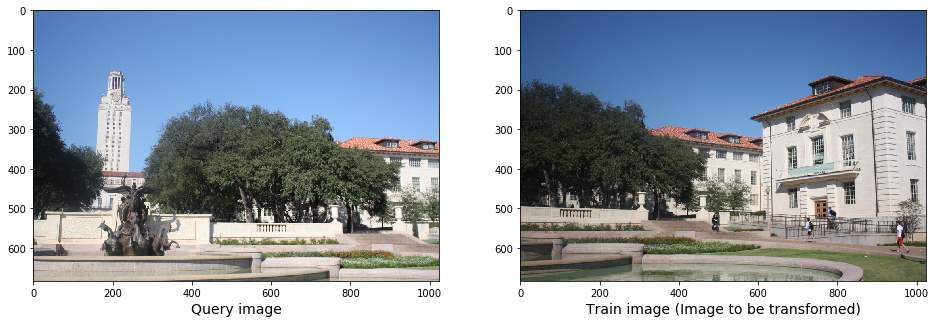

In [5]:
# read images and transform them to grayscale
# Make sure that the train image is the image that will be transformed
trainImg = cv2.imread(IMAGEA)[:,:,::-1]
trainImg_gray = cv2.cvtColor(trainImg, cv2.COLOR_RGB2GRAY)

queryImg = cv2.imread(IMAGEB)[:,:,::-1]
# Opencv defines the color channel in the order BGR. 
# Transform it to RGB to be compatible to matplotlib
queryImg_gray = cv2.cvtColor(queryImg, cv2.COLOR_RGB2GRAY)

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, constrained_layout=False, figsize=(16,9))
ax1.imshow(queryImg, cmap="gray")
ax1.set_xlabel("Query image", fontsize=14)

ax2.imshow(trainImg, cmap="gray")
ax2.set_xlabel("Train image (Image to be transformed)", fontsize=14)

plt.show()

In [6]:
def detectAndDescribe(image, method=None):
    """
    Compute key points and feature descriptors using an specific method
    """
    
    assert method is not None, "You need to define a feature detection method. Values are: 'sift', 'surf'"
    
    # detect and extract features from the image
    if method == 'sift':
        descriptor = cv2.xfeatures2d.SIFT_create()
    elif method == 'surf':
        descriptor = cv2.xfeatures2d.SURF_create()
    elif method == 'brisk':
        descriptor = cv2.BRISK_create()
    elif method == 'orb':
        descriptor = cv2.ORB_create()

    # get keypoints and descriptors
    (kps, features) = descriptor.detectAndCompute(image, None)
    
    return (kps, features)

In [7]:
kpsA, featuresA = detectAndDescribe(trainImg_gray, method=feature_extractor)
kpsB, featuresB = detectAndDescribe(queryImg_gray, method=feature_extractor)

In [8]:
def drawKey(img, kps, color=(0, 255, 0)):
    for marker in kps:
        cv2.circle(img, tuple(int(i) for i in marker.pt), 5, color=color, thickness=2)
    return img

Text(0.5, 0, '(b)')

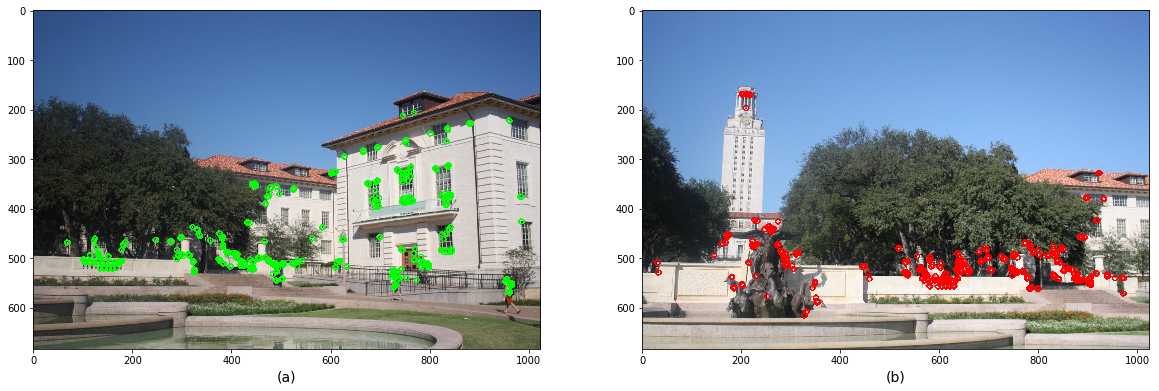

In [9]:
# display the keypoints and features detected on both images
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20,8), constrained_layout=False)
_img1 = drawKey(trainImg.copy(), kpsA)
_img2 = drawKey(queryImg.copy(), kpsB, (255,0,0))
ax1.imshow(_img1)
ax1.set_xlabel("(a)", fontsize=14)
ax2.imshow(_img2)
ax2.set_xlabel("(b)", fontsize=14)
    

In [10]:
def createMatcher(method,crossCheck):
    "Create and return a Matcher Object"
    
    if method == 'sift' or method == 'surf':
        bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=crossCheck)
    elif method == 'orb' or method == 'brisk':
        bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=crossCheck)
    return bf

In [11]:
def matchKeyPointsBF(featuresA, featuresB, method):
    bf = createMatcher(method, crossCheck=True)
        
    # Match descriptors.
    best_matches = bf.match(featuresA,featuresB)
    
    # Sort the features in order of distance.
    # The points with small distance (more similarity) are ordered first in the vector
    rawMatches = sorted(best_matches, key = lambda x:x.distance)
    print("Raw matches (Brute force):", len(rawMatches))
    return rawMatches, best_matches

In [12]:
def matchKeyPointsKNN(featuresA, featuresB, ratio, method):
    bf = createMatcher(method, crossCheck=False)
    # compute the raw matches and initialize the list of actual matches
    rawMatches = bf.knnMatch(featuresA, featuresB, 2)
    print("Raw matches (knn):", len(rawMatches))
    matches = []

    # loop over the raw matches
    for m,n in rawMatches:
        # ensure the distance is within a certain ratio of each
        # other (i.e. Lowe's ratio test)
        if m.distance < n.distance * ratio:
            matches.append(m)
    return matches

In [13]:
print(featuresA.shape)
print(featuresB.shape)

(500, 32)
(500, 32)


Using: bf feature matcher
Raw matches (Brute force): 185


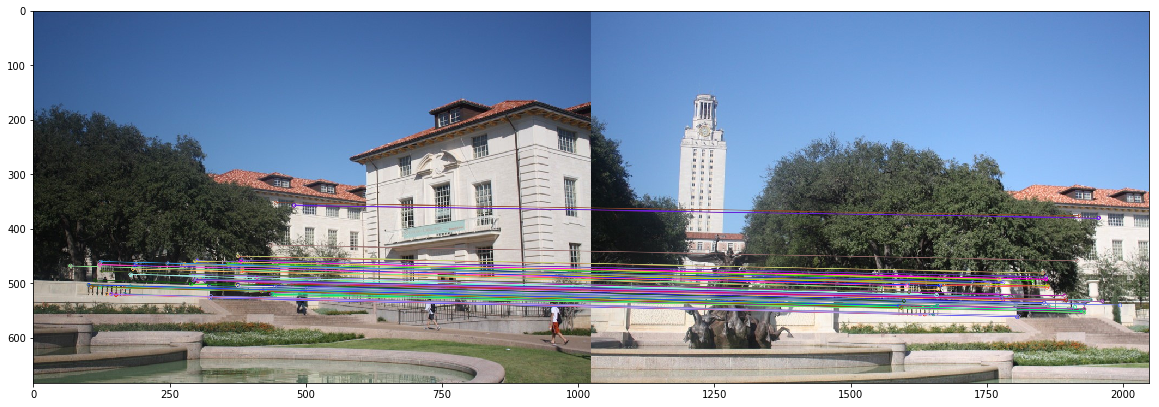

In [14]:
print("Using: {} feature matcher".format(feature_matching))

fig = plt.figure(figsize=(20,8))

if feature_matching == 'bf':
    matches, dump = matchKeyPointsBF(featuresA, featuresB, method=feature_extractor)
    img3 = cv2.drawMatches(trainImg,kpsA,queryImg,kpsB,matches[:100],
                           None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
elif feature_matching == 'knn':
    matches = matchKeyPointsKNN(featuresA, featuresB, ratio=0.75, method=feature_extractor)
    img3 = cv2.drawMatches(trainImg,kpsA,queryImg,kpsB,np.random.choice(matches,100),
                           None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    

plt.imshow(img3)
plt.show()

In [15]:
len(featuresB)

500

In [16]:
def getHomography(kpsA, kpsB, featuresA, featuresB, matches, reprojThresh):
    # convert the keypoints to numpy arrays
    kpsA = np.float32([kp.pt for kp in kpsA])
    kpsB = np.float32([kp.pt for kp in kpsB])
    
    if len(matches) > 4:

        # construct the two sets of points
        ptsA = np.float32([kpsA[m.queryIdx] for m in matches])
        ptsB = np.float32([kpsB[m.trainIdx] for m in matches])
        
        # estimate the homography between the sets of points
        (H, status) = cv2.findHomography(ptsA, ptsB, cv2.RANSAC,
            reprojThresh)

        return (matches, H, status, (ptsA, ptsB))
    else:
        return None

In [17]:
M = getHomography(kpsA, kpsB, featuresA, featuresB, matches, reprojThresh=4)
if M is None:
    print("Error!")
(matches, H, status, pts) = M


In [31]:
H

array([[ 7.92272362e-01,  8.22117652e-02,  4.34671442e+02],
       [-1.33501977e-01,  9.58413827e-01,  6.55962640e+01],
       [-2.09248580e-04,  1.60937718e-05,  1.00000000e+00]])

In [33]:
ptsA, ptsB = pts
matches = {"ptsA":ptsA, "ptsB":ptsB}
FILE = "matchespoints.npy"
np.save(FILE, matches)

In [54]:
a = np.load(FILE).tolist()
ptsA, ptsB = a['ptsA'], a['ptsB']

In [ ]:
def ransac(u, v, thresh):
    maxInliers = []
    H = None
    _, m = u.shape
    _u = np.empty((2,4),dtype=np.float32)
    _v = np.empty((2,4),dtype=np.float32)
    for i in range(1000):
        #find 4 random points to calculate a homography
        idx = np.random.randint(0, m, 4)
        _u = u[:,idx]
        _v = v[:,v]
        #call the homography function on those points
        h = calcHomographyLinear(_u, _v)
        inliers = []

        for i in range(len(corr)):
            d = geometricDistance(corr[i], h)
            if d < 5:
                inliers.append(corr[i])

        if len(inliers) > len(maxInliers):
            maxInliers = inliers
            finalH = h
        print "Corr size: ", len(corr), " NumInliers: ", len(inliers), "Max inliers: ", len(maxInliers)

        if len(maxInliers) > (len(corr)*thresh):
            break
    return finalH, maxInliers

In [ ]:
def ransac(corr, thresh):
    maxInliers = []
    finalH = None
    for i in range(1000):
        #find 4 random points to calculate a homography
        corr1 = corr[random.randrange(0, len(corr))]
        corr2 = corr[random.randrange(0, len(corr))]
        randomFour = np.vstack((corr1, corr2))
        corr3 = corr[random.randrange(0, len(corr))]
        randomFour = np.vstack((randomFour, corr3))
        corr4 = corr[random.randrange(0, len(corr))]
        randomFour = np.vstack((randomFour, corr4))

        #call the homography function on those points
        h = calculateHomography(randomFour)
        inliers = []

        for i in range(len(corr)):
            d = geometricDistance(corr[i], h)
            if d < 5:
                inliers.append(corr[i])

        if len(inliers) > len(maxInliers):
            maxInliers = inliers
            finalH = h
        print "Corr size: ", len(corr), " NumInliers: ", len(inliers), "Max inliers: ", len(maxInliers)

        if len(maxInliers) > (len(corr)*thresh):
            break
    return finalH, maxInliers

In [64]:
n = np.array([[1,2,3],[4,5,6]])


In [71]:
np.where([True,False,True])

(array([0, 2], dtype=int64),)

In [18]:
for i in range(4):
    tidx = matches[i].trainIdx
    qidx = matches[i].queryIdx
    print(kpsA[tidx].pt, kpsB[qidx].pt, np.dot(H,np.array([[kpsA[tidx].pt[0],kpsA[tidx].pt[1],1]]).T))

(475.0, 504.0) (905.0, 554.0) [[852.43554339]
 [485.22339411]
 [  0.90871819]]
(483.72955322265625, 512.39501953125) (447.8977355957031, 515.9782104492188) [[860.04189651]
 [492.1038843 ]
 [  0.90702665]]
(734.4000854492188, 323.1360168457031) (905.4721069335938, 537.4080810546875) [[1.04308191e+03]
 [2.77250428e+02]
 [8.51528302e-01]]
(761.4260864257812, 316.0167236328125) (870.9122314453125, 530.0122680664062) [[1.06390858e+03]
 [2.66819174e+02]
 [8.45758573e-01]]


In [54]:
_H = np.array([[ 8.1042480e-01,  5.6634683e-02,  4.3400992e+02],
 [-1.1243457e-01,  9.0425938e-01,  7.9941612e+01],
 [-1.7603381e-04, -2.6256635e-05,  1.0000000e+00]])

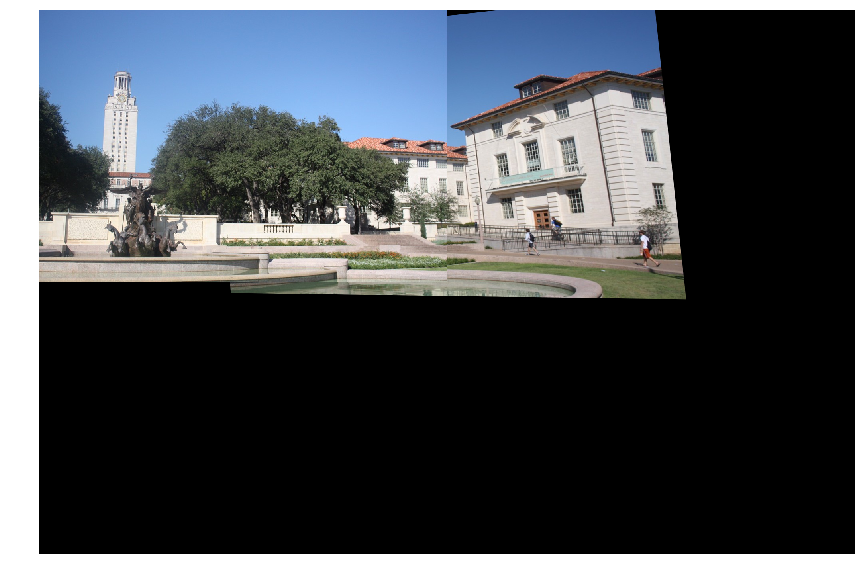

In [55]:
# Apply panorama correction
width = trainImg.shape[1] + queryImg.shape[1]
height = trainImg.shape[0] + queryImg.shape[0]

result = cv2.warpPerspective(trainImg, _H, (width, height))
result[0:queryImg.shape[0], 0:queryImg.shape[1]] = queryImg

plt.figure(figsize=(20,10))
plt.imshow(result)

plt.axis('off')
plt.show()

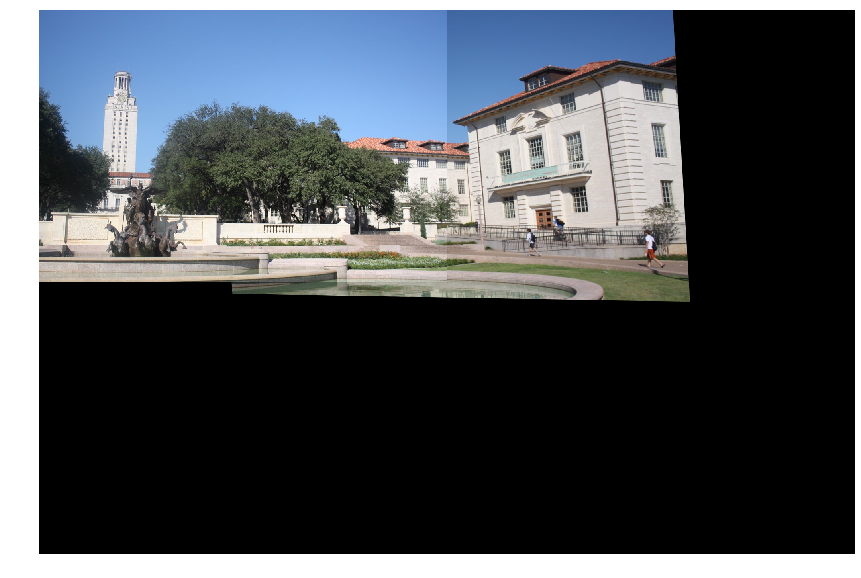

In [21]:
# Apply panorama correction
width = trainImg.shape[1] + queryImg.shape[1]
height = trainImg.shape[0] + queryImg.shape[0]

result = cv2.warpPerspective(trainImg, H, (width, height))
result[0:queryImg.shape[0], 0:queryImg.shape[1]] = queryImg

plt.figure(figsize=(20,10))
plt.imshow(result)

plt.axis('off')
plt.show()

In [111]:
# transform the panorama image to grayscale and threshold it 
gray = cv2.cvtColor(result, cv2.COLOR_BGR2GRAY)
thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY)[1]

# Finds contours from the binary image
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)

# get the maximum contour area
c = max(cnts, key=cv2.contourArea)

# get a bbox from the contour area
(x, y, w, h) = cv2.boundingRect(c)

# crop the image to the bbox coordinates
result = result[y:y + h, x:x + w]

# show the cropped image
plt.figure(figsize=(20,10))
plt.imshow(result)

NameError: name 'imutils' is not defined

In [ ]:
res = np.array([[52.69599991 52.73356864 52.74790183 52.70262161]
 [53.86378402 53.81282256 53.79337981 53.85480177]
 [ 0.08165572  0.07313664  0.06988645  0.08015418]] )
xT [[-2.50696386 -5.9552604   1.        ]
 [ 0.96999609  2.84768042  1.        ]
 [-3.60295508 -0.58000537  1.        ]
 [ 5.13992285  3.68758535  1.        ]] 
tv [[-1.16523714e-01  1.01298461e-01  2.10880092e+02]
 [ 1.58062757e-01 -1.37409919e-01  2.15324788e+02]
 [ 2.64228890e-02 -2.29704143e-02  3.04832992e-01]]
dv [-5.82618570e-04  5.06492304e-04  1.05440046e+00] val [ 0.78385814  0.08952657 55.65452024]
============== 65 ============ loss 946.2009562875855 0.02
pred [53.15626219 47.26972408  1.0479683 ]
res [[51.64315514 51.67829099 51.69169599 51.64934803]
 [52.78504981 52.73738852 52.71920484 52.77664924]
 [ 0.08130295  0.07333555  0.07029584  0.07989865]] 
xT [[-2.50696386 -5.9552604   1.        ]
 [ 0.96999609  2.84768042  1.        ]
 [-3.60295508 -0.58000537  1.        ]
 [ 5.13992285  3.68758535  1.        ]] 
tv [[-1.08977859e-01  9.47385642e-02  2.06662490e+02]
 [ 1.47826912e-01 -1.28511512e-01  2.11018292e+02]
 [ 2.47117927e-02 -2.14828938e-02  3.04832992e-01]]
dv [-5.44889293e-04  4.73692821e-04  1.03331245e+00] val [ 0.78440303  0.08905288 54.62120778]